# Introduction

This notebook contains the code used to generate the images on which the
`hcp-annot-vc` repository facilitates annotation. It was made to run on a
particular system once, so is not guaranteed to work well, but it does
document the process.

### Configuration

In [1]:
# The cache directories:
cache_path = '/data/crcns2021'
image_cache_path = '/data/crcns2021/annot-images'
v123_cache_path = '/data/crcns2021/annot-v123'
csulc_cache_path = '/data/crcns2021/annot-csulc'

### Dependencies

In [2]:
import os, sys, pimms, pandas, warnings
import numpy as np
import scipy as sp
import scipy.sparse as sps
import nibabel as nib
import multiprocessing as mproc
import neuropythy as ny

import matplotlib as mpl
import matplotlib.pyplot as plt
import ipyvolume as ipv
import torch, json

In [3]:
%matplotlib inline

In [4]:
# Additional matplotlib preferences:
font_data = {'family':'sans-serif',
             'sans-serif':['HelveticaNeue', 'Helvetica', 'Arial'],
             'size': 10,
             'weight': 'light'}
mpl.rc('font',**font_data)
# we want relatively high-res images, especially when saving to disk.
mpl.rcParams['figure.dpi'] = 72*2
mpl.rcParams['savefig.dpi'] = 72*4

### Import `hcpannot` and prep the `'hcp_lines'` dataset

In [5]:
# Make sure we are in the right directory for this!
cwd = os.getcwd()
if cwd.endswith('hcp-annot-vc/work'):
    os.chdir('..')
    cwd = os.getcwd()
# Now we can import the hcp-annot-v123 library.
import hcpannot
# Note the cache path we want to use outside the docker container.
hcpannot.interface.default_cache_path = cache_path
# We want to grab a few variables from hcpannot:
roi_image_shape = hcpannot.interface.default_imshape
roi_image_shape = roi_image_shape[0] // 2
imgrid_to_flatmap = hcpannot.interface.imgrid_to_flatmap
flatmap_to_imgrid = hcpannot.interface.flatmap_to_imgrid

In [6]:
# For each subject in the hcp_lines dataset, we want to generate a simple version
# of their lines on the flatmap that we use for them.
hcplns = ny.data['hcp_lines']
sids = hcplns.subject_list

## Work

### Subject Lists

In [7]:
subject_list_1 = np.array(
    [100610, 102311, 102816, 104416, 105923, 108323, 109123, 111312,
     111514, 114823, 115017, 115825, 116726, 118225, 125525, 126426,
     128935, 130114, 130518, 131217, 132118, 145834, 146735, 157336,
     158136, 164131, 167036, 169747, 173334, 175237, 182436, 192439,
     198653, 201515, 203418, 214019, 221319, 318637, 320826, 346137,
     360030, 365343, 385046, 393247, 401422, 406836, 467351, 525541,
     573249, 581450, 627549, 644246, 671855, 690152, 732243, 783462,
     814649, 878776, 898176, 958976])
subject_list_2 = np.array(
    [134627, 140117, 146129, 148133, 155938, 158035, 159239, 164636,
     165436, 167440, 169040, 169343, 171633, 176542, 177140, 178647,
     181636, 182739, 187345, 191336, 191841, 192641, 195041, 199655,
     204521, 205220, 212419, 233326, 239136, 246133, 251833, 263436,
     283543, 389357, 395756, 429040, 436845, 541943, 550439, 552241,
     601127, 638049, 724446, 751550, 757764, 765864, 770352, 782561,
     818859, 825048, 859671, 871762, 878877, 899885, 910241, 927359,
     942658, 951457, 971160, 973770])
subject_list_3 = np.sort(
    np.setdiff1d(hcpannot.subject_ids,
                 np.concatenate([subject_list_1, subject_list_2])))

### Saving out V1-V3 Expert Line Data

In [13]:
# These are the contours we want to export (the others are just sub-contours).
core_contours = [
    # Iso-eccentricity:
    '0.5','1','2','4','7',
    # Boundaries:
    'V1_dorsal', 'V1_mid', 'V1_ventral',
    'V2_dorsal', 'V2_ventral',
    'V3_dorsal', 'V3_ventral']
# The function that does the work (in another process).
def gen_sub_v123(sid, save_path=v123_cache_path):
    flnm = os.path.join(save_path, '%d.json.gz' % (sid,))
    if os.path.isfile(flnm): return flnm
    sub = hcplns.subjects[sid]
    # Get the lines:
    try: lns = hcplns.fsaverage_paths['mean'][sid]
    except Exception: return None
    # For each of these, put
    them in a simple data structure using the flatmaps.
    res = {}
    for h in ['lh','rh']:
        hemi = sub.hemis[h]
        hlns = lns[h]
        fmap = hcpannot.op_flatmap(hemi)
        r = {}
        for (a,adat) in hlns.items():
            for (k,path) in adat.items():
                if k not in core_contours: continue
                pts = fmap.unaddress(path.addresses)
                # Just save these points.
                r[k] = pts
        if len(r) > 0: res[h] = r
    if len(res) == 0: res = None
    # Now we just want to write these out to JSON files.
    return ny.save(flnm, res)
# This one generates all the subjects by multiprocessing across CPUs.
def gen_v123(sids=sids, nproc=-1):
    import multiprocessing as mp
    if nproc is None or nproc == 0: nproc = mp.cpu_count()
    elif nproc < 0: nproc = mp.cpu_count() + nproc
    if nproc < 1: raise ValueError(f"nproc = {nproc}")
    n = len(sids)
    for ii in np.arange(0, n, nproc):
        jj = min(n, ii + nproc)
        with mp.Pool(nproc) as pool:
            pool.map(gen_sub_v123, sids[ii:jj])
    return n

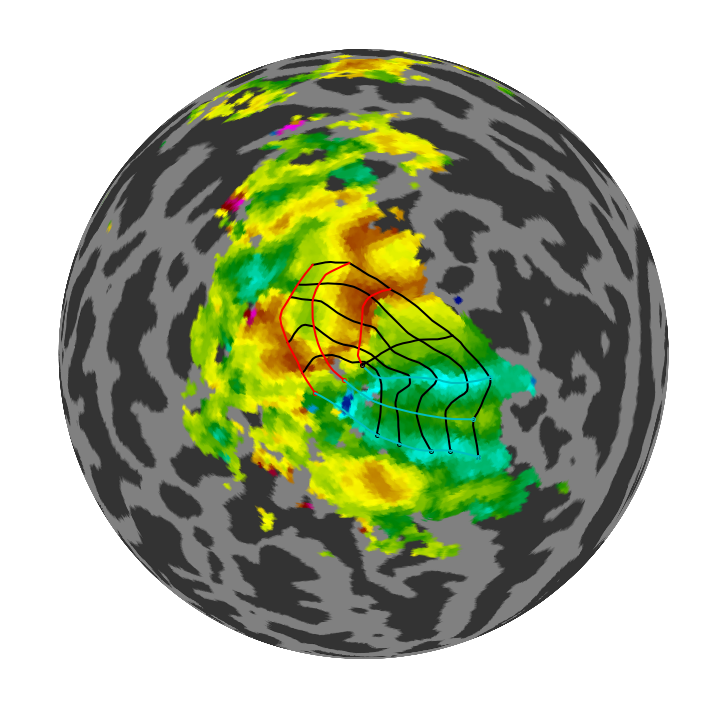

In [29]:
# This cell plots a sample hemisphere's flatmap with the lines that were
# just written out in the cell above as a test.

# The subject and hemisphere to plot.
sid = sids[100]
h = 'lh'

# Make the figure and axes.
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=72*4)

# Load the subject's contour data.
p = ny.load(os.path.join(v123_cache_path, f'{sid}.json.gz'))
p = p[h]
# And make the subject's flatmap.
sub = hcplns.subjects[sid]
fmap = hcpannot.op_flatmap(sub.hemis[h])
ny.cortex_plot(fmap, color='prf_polar_angle', mask=('prf_variance_explained', 0.1, 1),
               axes=ax)

for (k,(x,y)) in p.items():
    c = 'r' if k.endswith('_dorsal') else 'c' if k.endswith('_ventral') else 'k'
    ax.plot(x, y, c + '-', lw=0.5)
    ax.plot(x[0], y[0], c + '.', ms=0.5)

ax.axis('equal')
ax.axis('off')
pass

### Saving out Cortical Sulc contours

In [86]:
csulc_labels = [
    (2,  'Inferior Occipital Gyrus',            'IOG', [ 0.5,  0.5,    1]),
    (3,  'Fusiform Gyrus',                       'FG', [   0,    0,    1]),
    (6,  'Calcarine Sulcus',                    'CaS', [   1,    1,    1]),
    (7,  'Occipito-Temporal Sulcus',            'OTS', [ 0.5,    1,  0.5]),
    (8,  'Mid-Fusiform Sulcus',                 'mFS', [   0,    0,  0.5]),
    (13, 'Intra-Parietal Sulcus',               'IPS', [0.25,    0,    0]),
    (15, 'Posterior Superior Temporal Sulcus', 'pSTS', [   1,    1, 0.25]),
    (16, 'Posterior Lingual Sulcus',            'PLS', [0.25,    0, 0.25]),
    (19, 'Superior Temporal Sulcus',            'STS', [   1,  0.5,    0]),
    (21, 'Anterior Lingual Sulcus',             'ALS', [ 0.5,    0,  0.5]),
    (23, 'Lateral Occipital Sulcus',            'LOS', [   0,    0,    0]),
    (24, 'Transverse Occipital Sulcus',         'TOS', [   1,  0.5,  0.5]),
    (25, 'Collateral Sulcus',                   'CoS', [   1,    0,    1]),
    (26, 'Inferior Temporal Sulcus',            'ITS', [   0,  0.5,    0]),
    (27, 'Posterior Collateral Sulcus',       'ptCoS', [   1, 0.75,    1]),
    (28, 'Parietal-Occipital Sulcus',           'POS', [   1,    0,    0])
]
csulc_abbrevs = {lbl: abbrev for (lbl,nm,abbrev,clr) in csulc_labels}
csulc_numbers = {abbrev: lbl for (lbl,nm,abbrev,clr) in csulc_labels}

csulc = {h: ny.load(f'/data/hcp/lines/visual_sulc/{h}.corticalsulc.mgz')
         for h in ['lh','rh']}
fsa_with_csulc = ny.freesurfer_subject('fsaverage')
fsa_with_csulc = fsa_with_csulc.with_hemi(
    lh=fsa_with_csulc.lh.with_prop(csulc=csulc['lh']),
    rh=fsa_with_csulc.rh.with_prop(csulc=csulc['rh']))
def sub_with_csulc(sid):
    sub = hcplns.subjects[sid]
    css = {h: fsa_with_csulc.hemis[h].interpolate(sub.hemis[h], 'csulc')
           for h in ['lh','rh']}
    return sub.with_hemi(lh=sub.lh.with_prop(csulc=css['lh']),
                         rh=sub.rh.with_prop(csulc=css['rh']))

# The function that does the work (in another process).
def gen_sub_csulc(sid, save_path=csulc_cache_path):
    flnm = os.path.join(save_path, '%d.json.gz' % (sid,))
    if os.path.isfile(flnm): return flnm
    sub = sub_with_csulc(sid)
    # For each of these, put them in a simple data structure using the flatmaps.
    res = {}
    for h in ['lh','rh']:
        hemi = sub.hemis[h]
        fmap = hcpannot.op_flatmap(hemi)
        sulc = fmap.prop('csulc')
        r = {}
        for (lbl, name, abbrev, clr) in csulc_labels:
            lns = fmap.isolines((sulc == lbl).astype('float'), 0.85)
            if len(lns) == 0:
                warnings.warn(f"No lines for {sid}/{h}: {abbrev}")
            else:
                lns = sorted(lns, key=lambda l:-len(l))
                r[abbrev] = lns[0]
        if len(r) > 0: res[h] = r
    if len(res) == 0: res = None
    # Now we just want to write these out to JSON files.
    return ny.save(flnm, res)
# This one generates all the subjects by multiprocessing across CPUs.
def gen_csulc(sids=sids, nproc=-1):
    import multiprocessing as mp
    if nproc is None or nproc == 0: nproc = mp.cpu_count()
    elif nproc < 0: nproc = mp.cpu_count() + nproc
    if nproc < 1: raise ValueError(f"nproc = {nproc}")
    n = len(sids)
    for ii in np.arange(0, n, nproc):
        jj = min(n, ii + nproc)
        with mp.Pool(nproc) as pool:
            pool.map(gen_sub_csulc, sids[ii:jj])
    return n

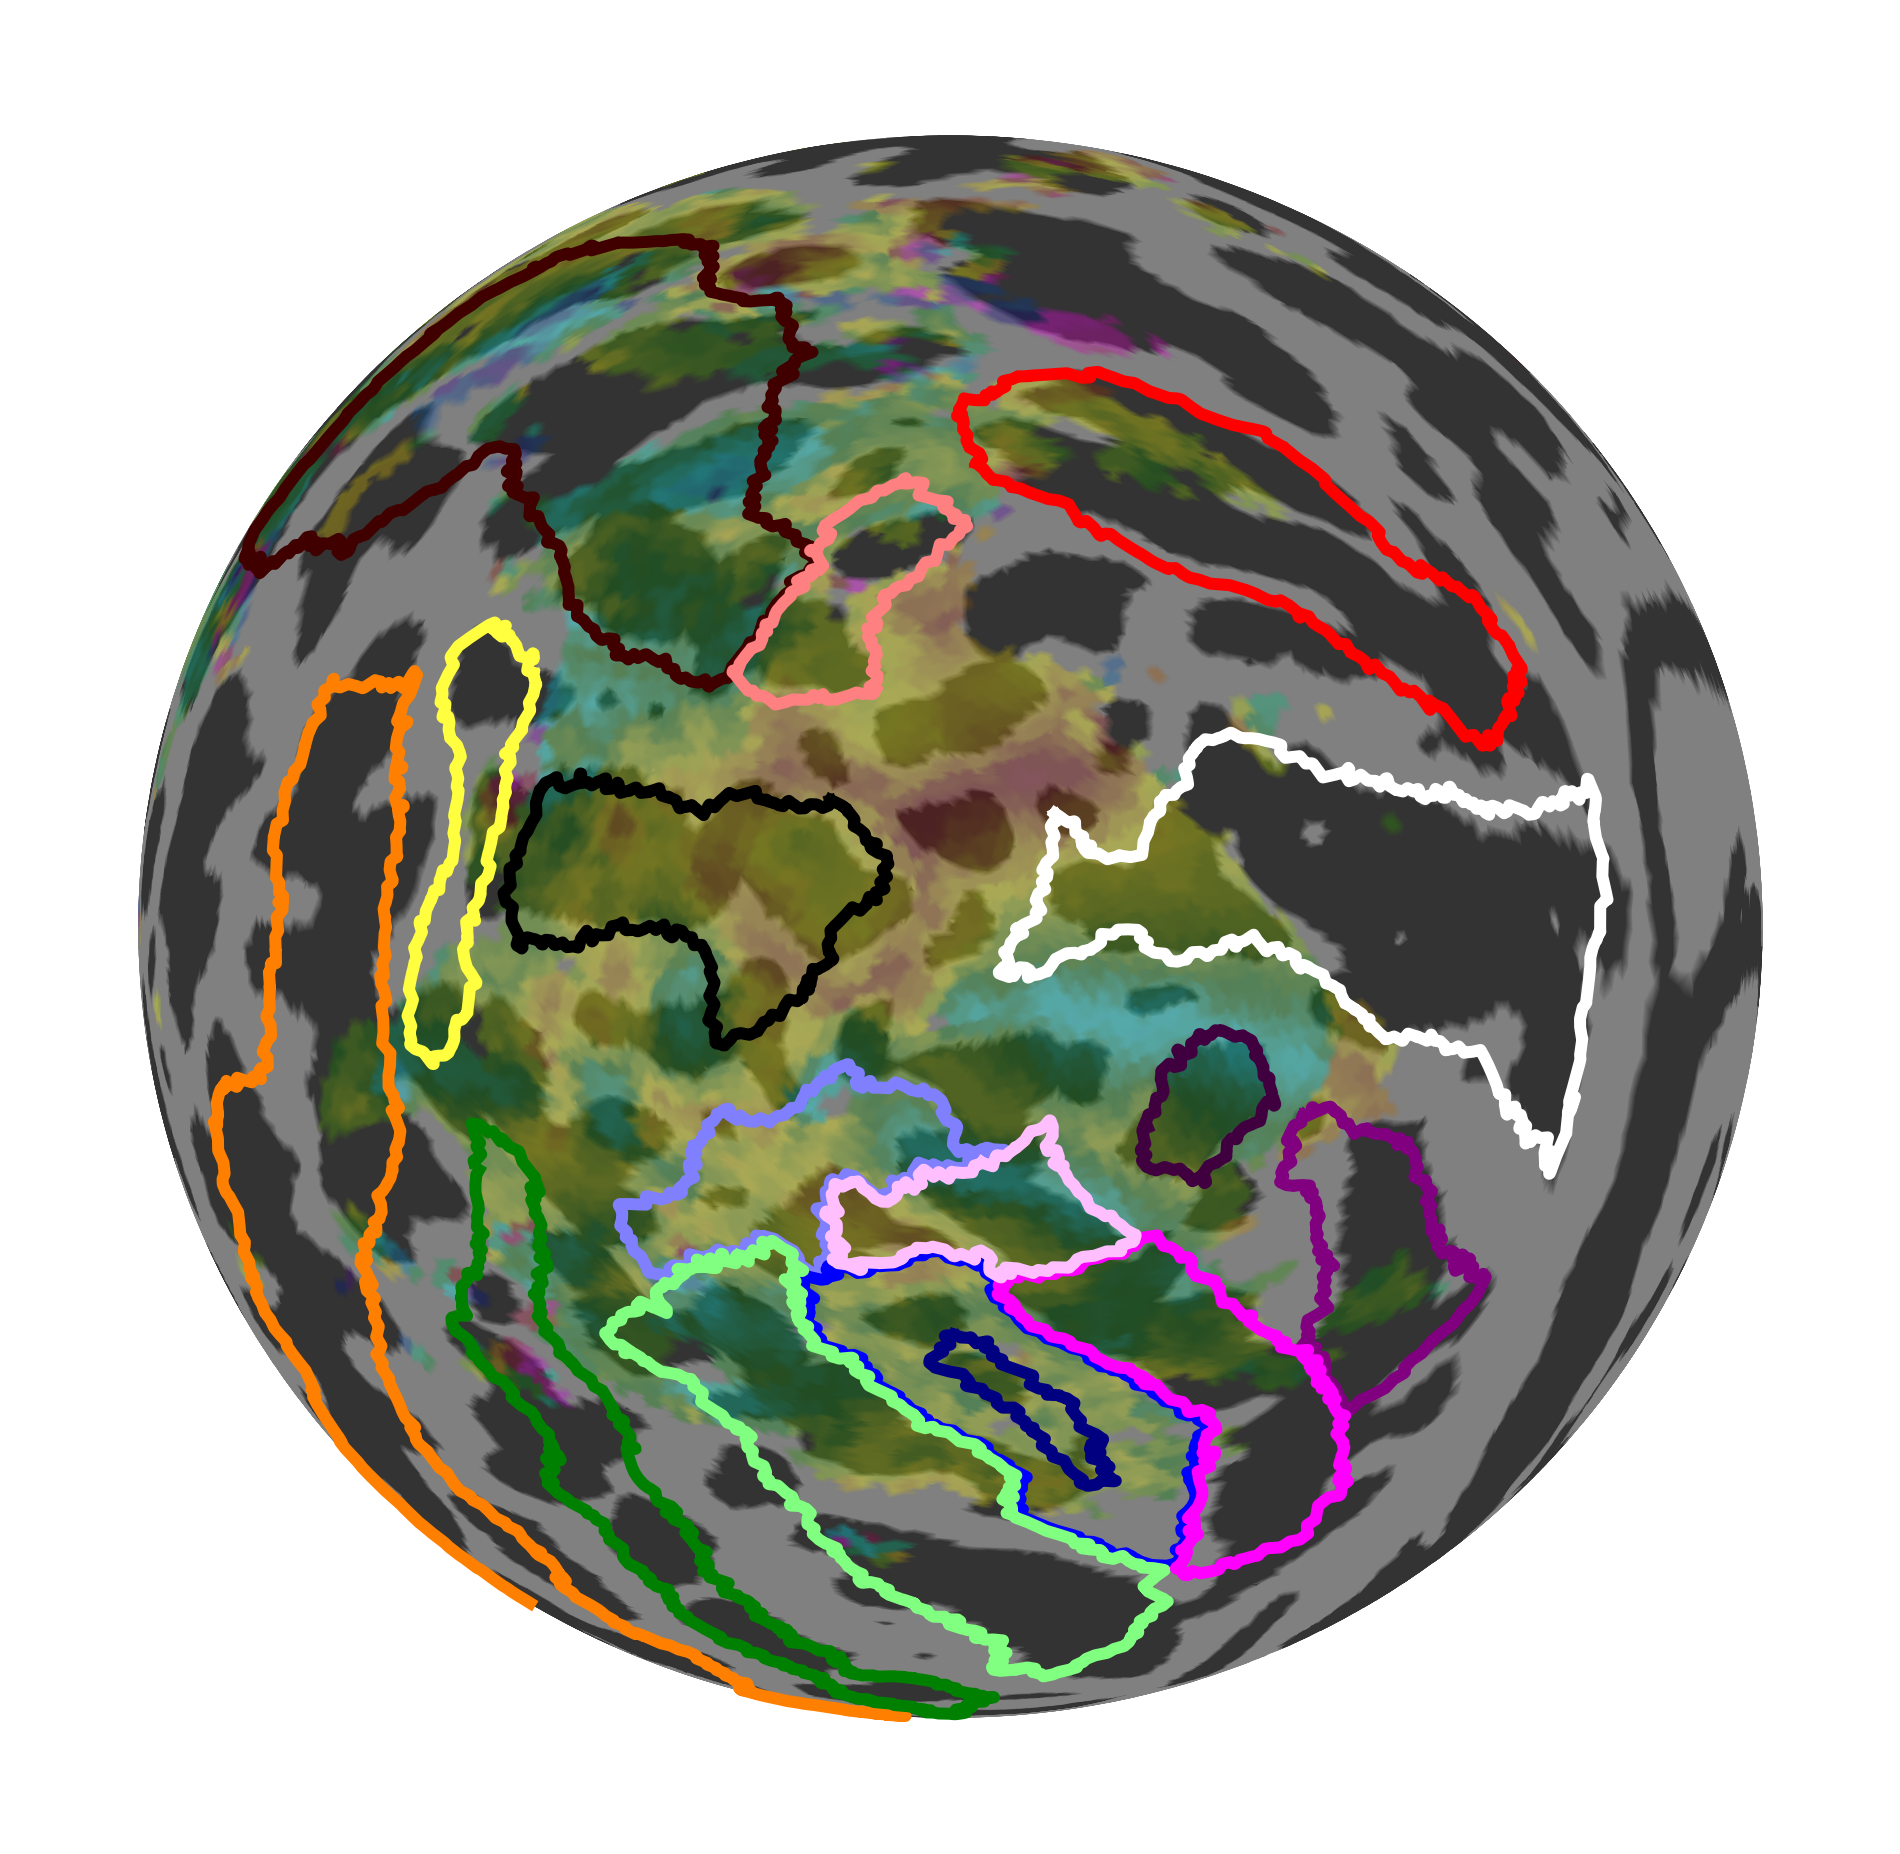

In [88]:
(sid, h) = (111312, 'lh')

#sub = sub_with_csulc(sid)
fm = hcpannot.op_flatmap(sub.hemis[h])
lns = ny.load(os.path.join(csulc_cache_path, f'{sid}.json.gz'))
lns = lns[h]

(fig,ax) = plt.subplots(1,1, figsize=(4,4), dpi=72*8)
ny.cortex_plot(fm, color='prf_polar_angle', alpha=0.33,
               mask=('prf_variance_explained', 0.05, 1),
               axes=ax)

for (lbl, name, abbrev, clr) in csulc_labels:
    (x,y) = lns[abbrev]
    ax.plot(x, y, '-', color=clr)

ax.axis('off')

pass

### Saving out Flatmap Images

In [31]:
def save_images(sid, h=None, cache_path=image_cache_path, image_names=('eccpeak_6.25',)):
    import PIL
    if h is None: (sid,h) = sid
    # Extract the image we want
    ims = None
    fls = []
    for imnm in image_names:
        flnm = os.path.join(cache_path, str(sid), f"{sid}_{h}_{imnm}.png")
        if os.path.isfile(flnm): continue
        # Make sure we have a flatmap and the images:
        if ims is None:
            sub = hcplns.subjects[sid]
            fmap = hcpannot.op_flatmap(sub.hemis[h])
            # Make the images for this subject:
            ims = hcpannot.core.generate_images(fmap)
        im = PIL.Image.fromarray(ims[imnm])
        im.save(flnm)
        fls.append(flnm)
    return fls

In [33]:
import multiprocessing as mp

nprocs = 10
jobs = [(sid,h) for sid in sids for h in ('lh','rh')]
njobs = len(jobs)

for ii in range(0, njobs, nprocs):
    jj = min(ii+nprocs, njobs)
    jobslice = jobs[ii:jj]
    with mp.Pool(len(jobslice)) as p:
        p.map(save_images, jobslice)
    print(" %3d / %d  (%5.2f%%)" % (ii+jj, njobs, jj*100/njobs))

  10 / 362  ( 2.76%)
  30 / 362  ( 5.52%)
  50 / 362  ( 8.29%)
  70 / 362  (11.05%)
  90 / 362  (13.81%)
 110 / 362  (16.57%)
 130 / 362  (19.34%)
 150 / 362  (22.10%)
 170 / 362  (24.86%)
 190 / 362  (27.62%)
 210 / 362  (30.39%)
 230 / 362  (33.15%)
 250 / 362  (35.91%)
 270 / 362  (38.67%)
 290 / 362  (41.44%)
 310 / 362  (44.20%)
 330 / 362  (46.96%)
 350 / 362  (49.72%)
 370 / 362  (52.49%)
 390 / 362  (55.25%)
 410 / 362  (58.01%)
 430 / 362  (60.77%)
 450 / 362  (63.54%)
 470 / 362  (66.30%)
 490 / 362  (69.06%)
 510 / 362  (71.82%)
 530 / 362  (74.59%)
 550 / 362  (77.35%)
 570 / 362  (80.11%)
 590 / 362  (82.87%)
 610 / 362  (85.64%)
 630 / 362  (88.40%)
 650 / 362  (91.16%)
 670 / 362  (93.92%)
 690 / 362  (96.69%)
 710 / 362  (99.45%)
 722 / 362  (100.00%)
